In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from itertools import product
import re

import mp_run
import conf_interval

from os import listdir
from os.path import isfile, join
from sklearn.metrics import mean_squared_error, explained_variance_score

import os

from sklearn.model_selection import cross_val_score
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from scipy import stats

from multiprocessing import Pool, cpu_count


%load_ext autoreload
%autoreload 2

# regex for number extraction from string
number_pattern =  r'(-?(?:0|[1-9]\d*)(?:\.\d+)?(?:[eE][+-]?\d+)?)'

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':200})

In [91]:
res_df_list = [
    pd.read_csv('./yeast_network_v_model.csv', index_col=0),
    pd.read_csv('./bsubtilis_network_v_model.csv', index_col=0),
    pd.read_csv('./arabidopsis_network_v_model.csv', index_col=0)
]

species_names = ['Yeast', 'B.subtilis', 'Arabidopsis']

filtered_df_list = [res_df[res_df['test_std'] > 0.5] for res_df in res_df_list]



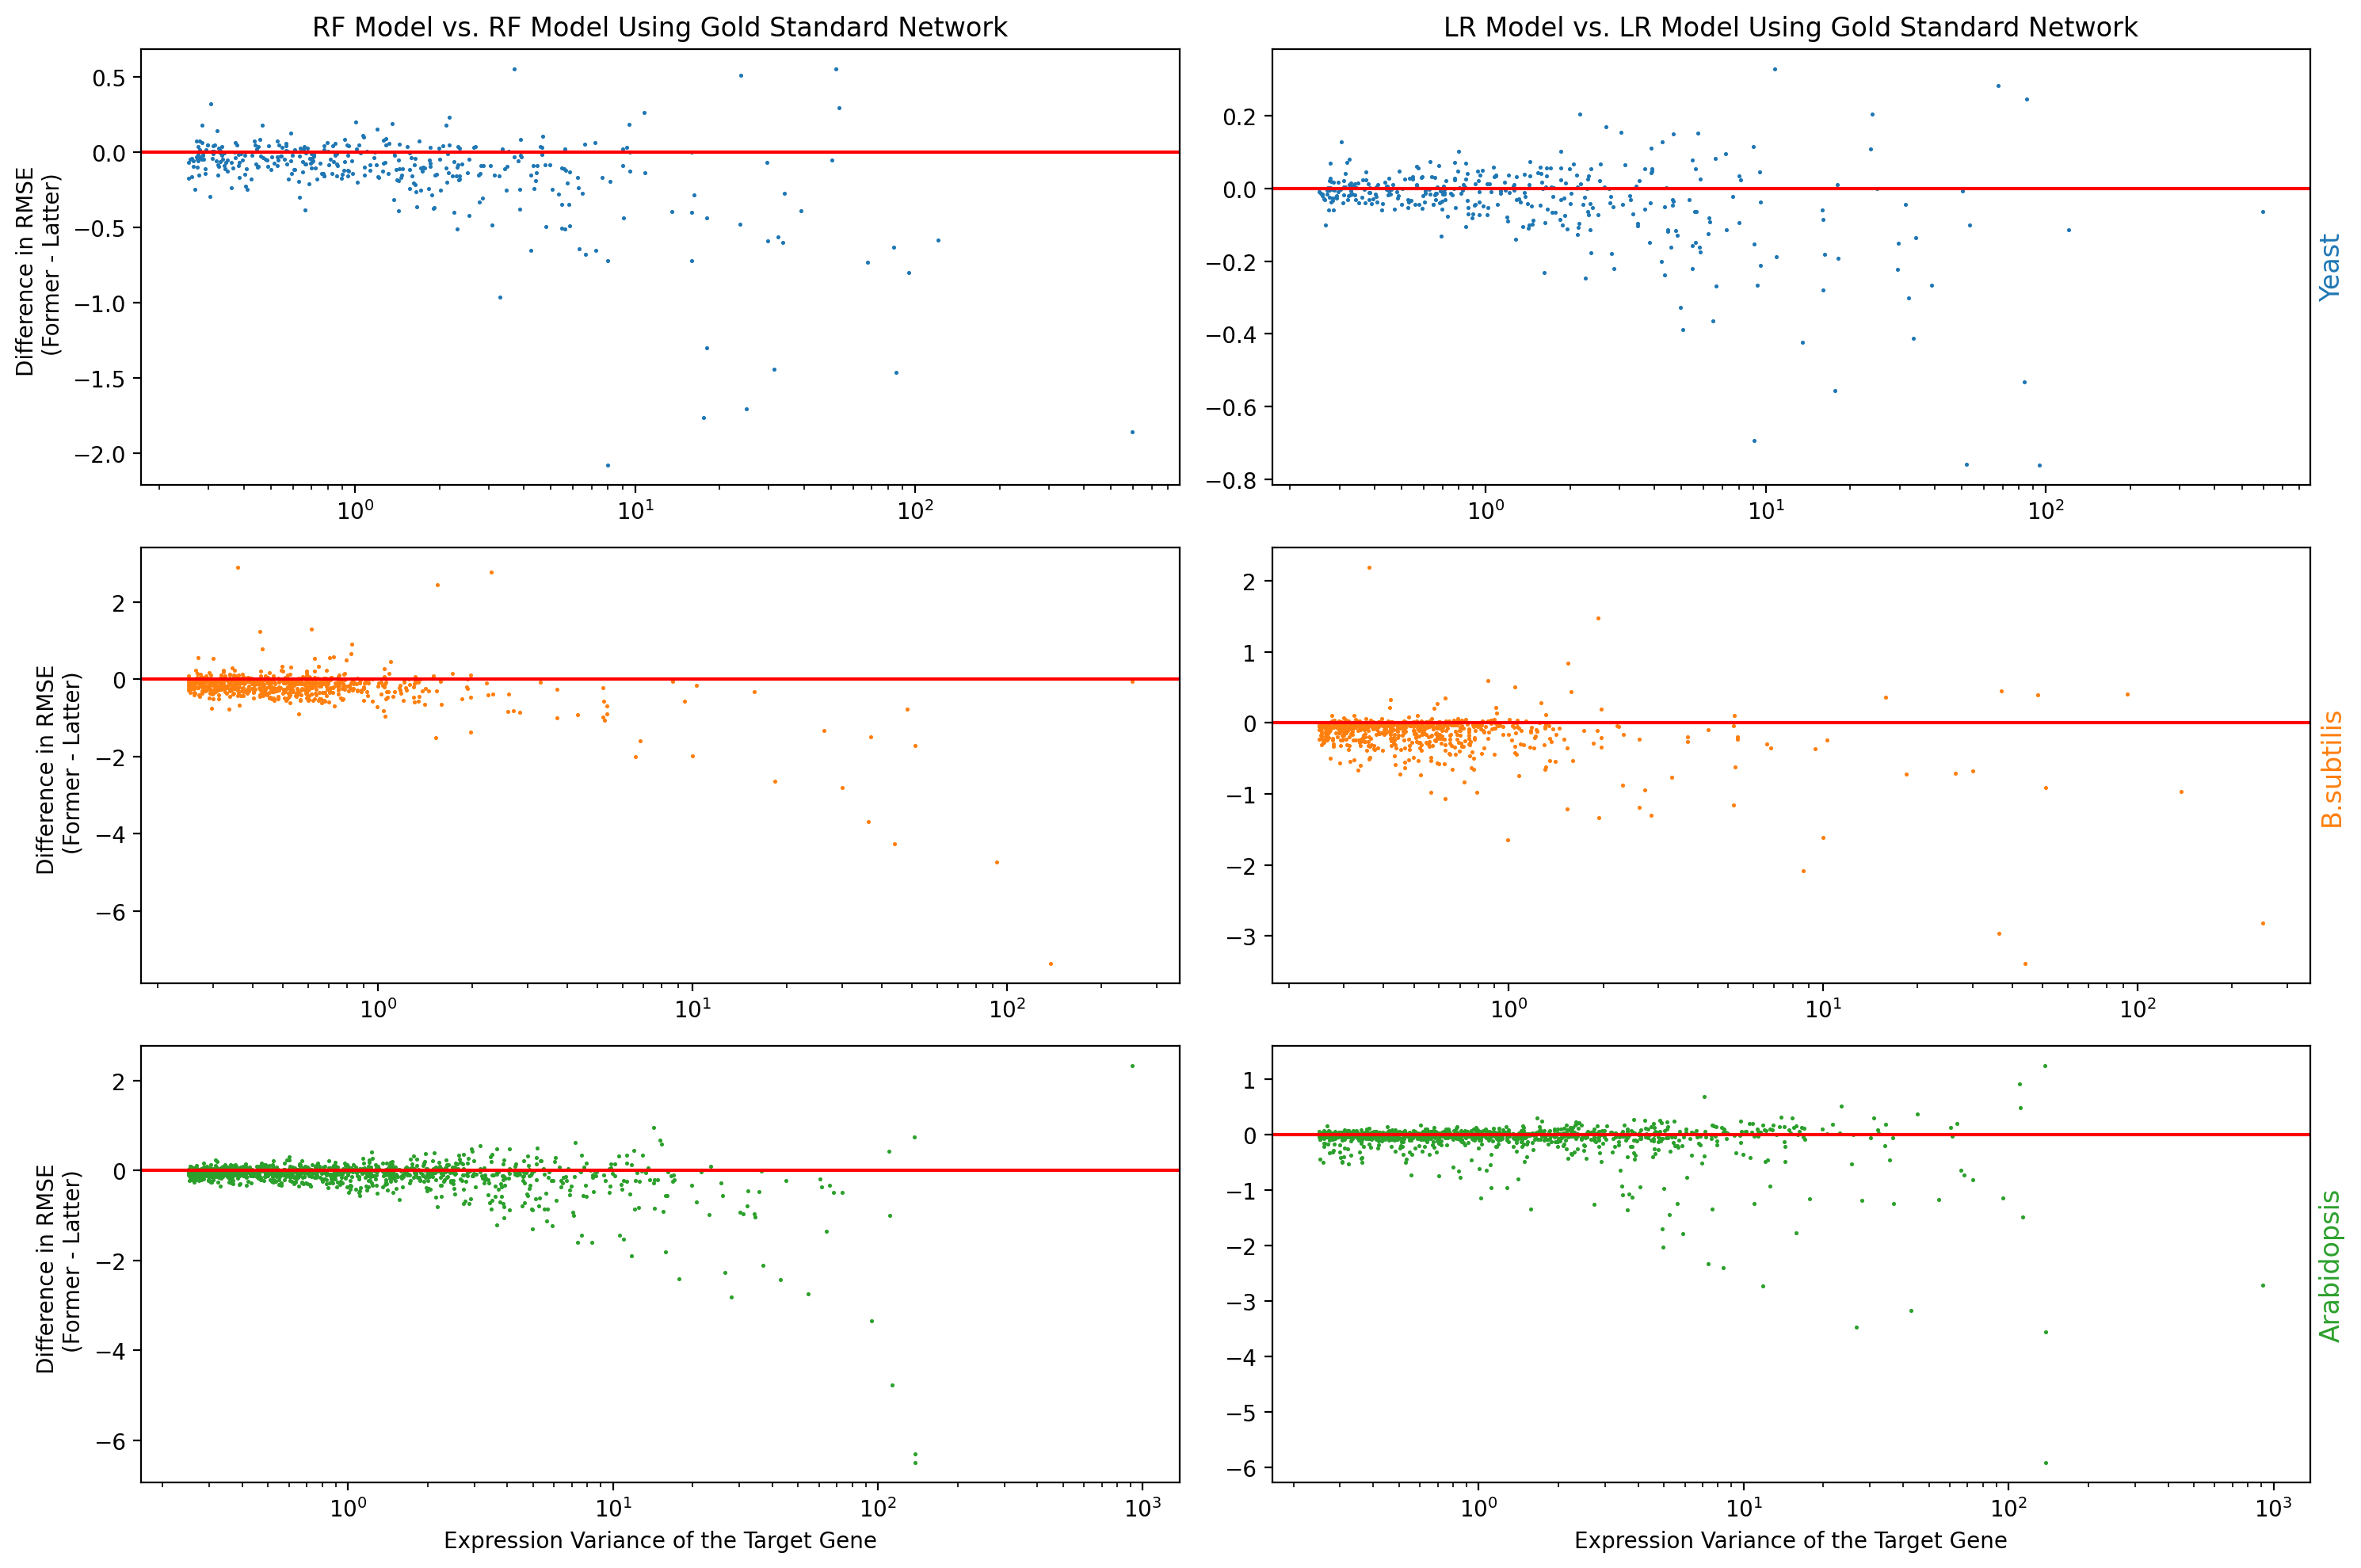

In [92]:
a = 'linear_rmse'
b = 'gs_linear_rmse'
c = 'rf_rmse'
d = 'gs_rf_rmse'

fig, axs = plt.subplots(3, 2, figsize=(15, 10))

for i in range(3):
    df = filtered_df_list[i]
    diff = df[a] - df[b]
    axs[i, 0].scatter(df['test_var'], diff, s=0.7, color=plt.cm.tab10(i))
    # plt.scatter(range(len(diff)),diff, s=0.2)
    axs[i, 0].axhline(y=0, color='r', linestyle='-')
    axs[i, 0].set_xscale('log')
    
    diff = df[c] - df[d]
    axs[i, 1].scatter(df['test_var'], diff, s=0.7, color=plt.cm.tab10(i))
    # plt.scatter(range(len(diff)),diff, s=0.2)
    axs[i, 1].axhline(y=0, color='r', linestyle='-')
    axs[i, 1].set_xscale('log')
    
for i in range(3):
    axs[i, 0].set(ylabel='Difference in RMSE \n (Former - Latter)')
    axs[i, 1].set_ylabel(species_names[i], color=plt.cm.tab10(i), size='large')
    axs[i, 1].yaxis.set_label_position("right")

axs[2, 0].set(xlabel='Expression Variance of the Target Gene')
axs[2, 1].set(xlabel='Expression Variance of the Target Gene')

axs[0, 0].set_title('RF Model vs. RF Model Using Gold Standard Network')
axs[0, 1].set_title('LR Model vs. LR Model Using Gold Standard Network')
fig.tight_layout()
fig.savefig('./plot_output/all_v_gs.pdf', format='pdf', dpi=300)

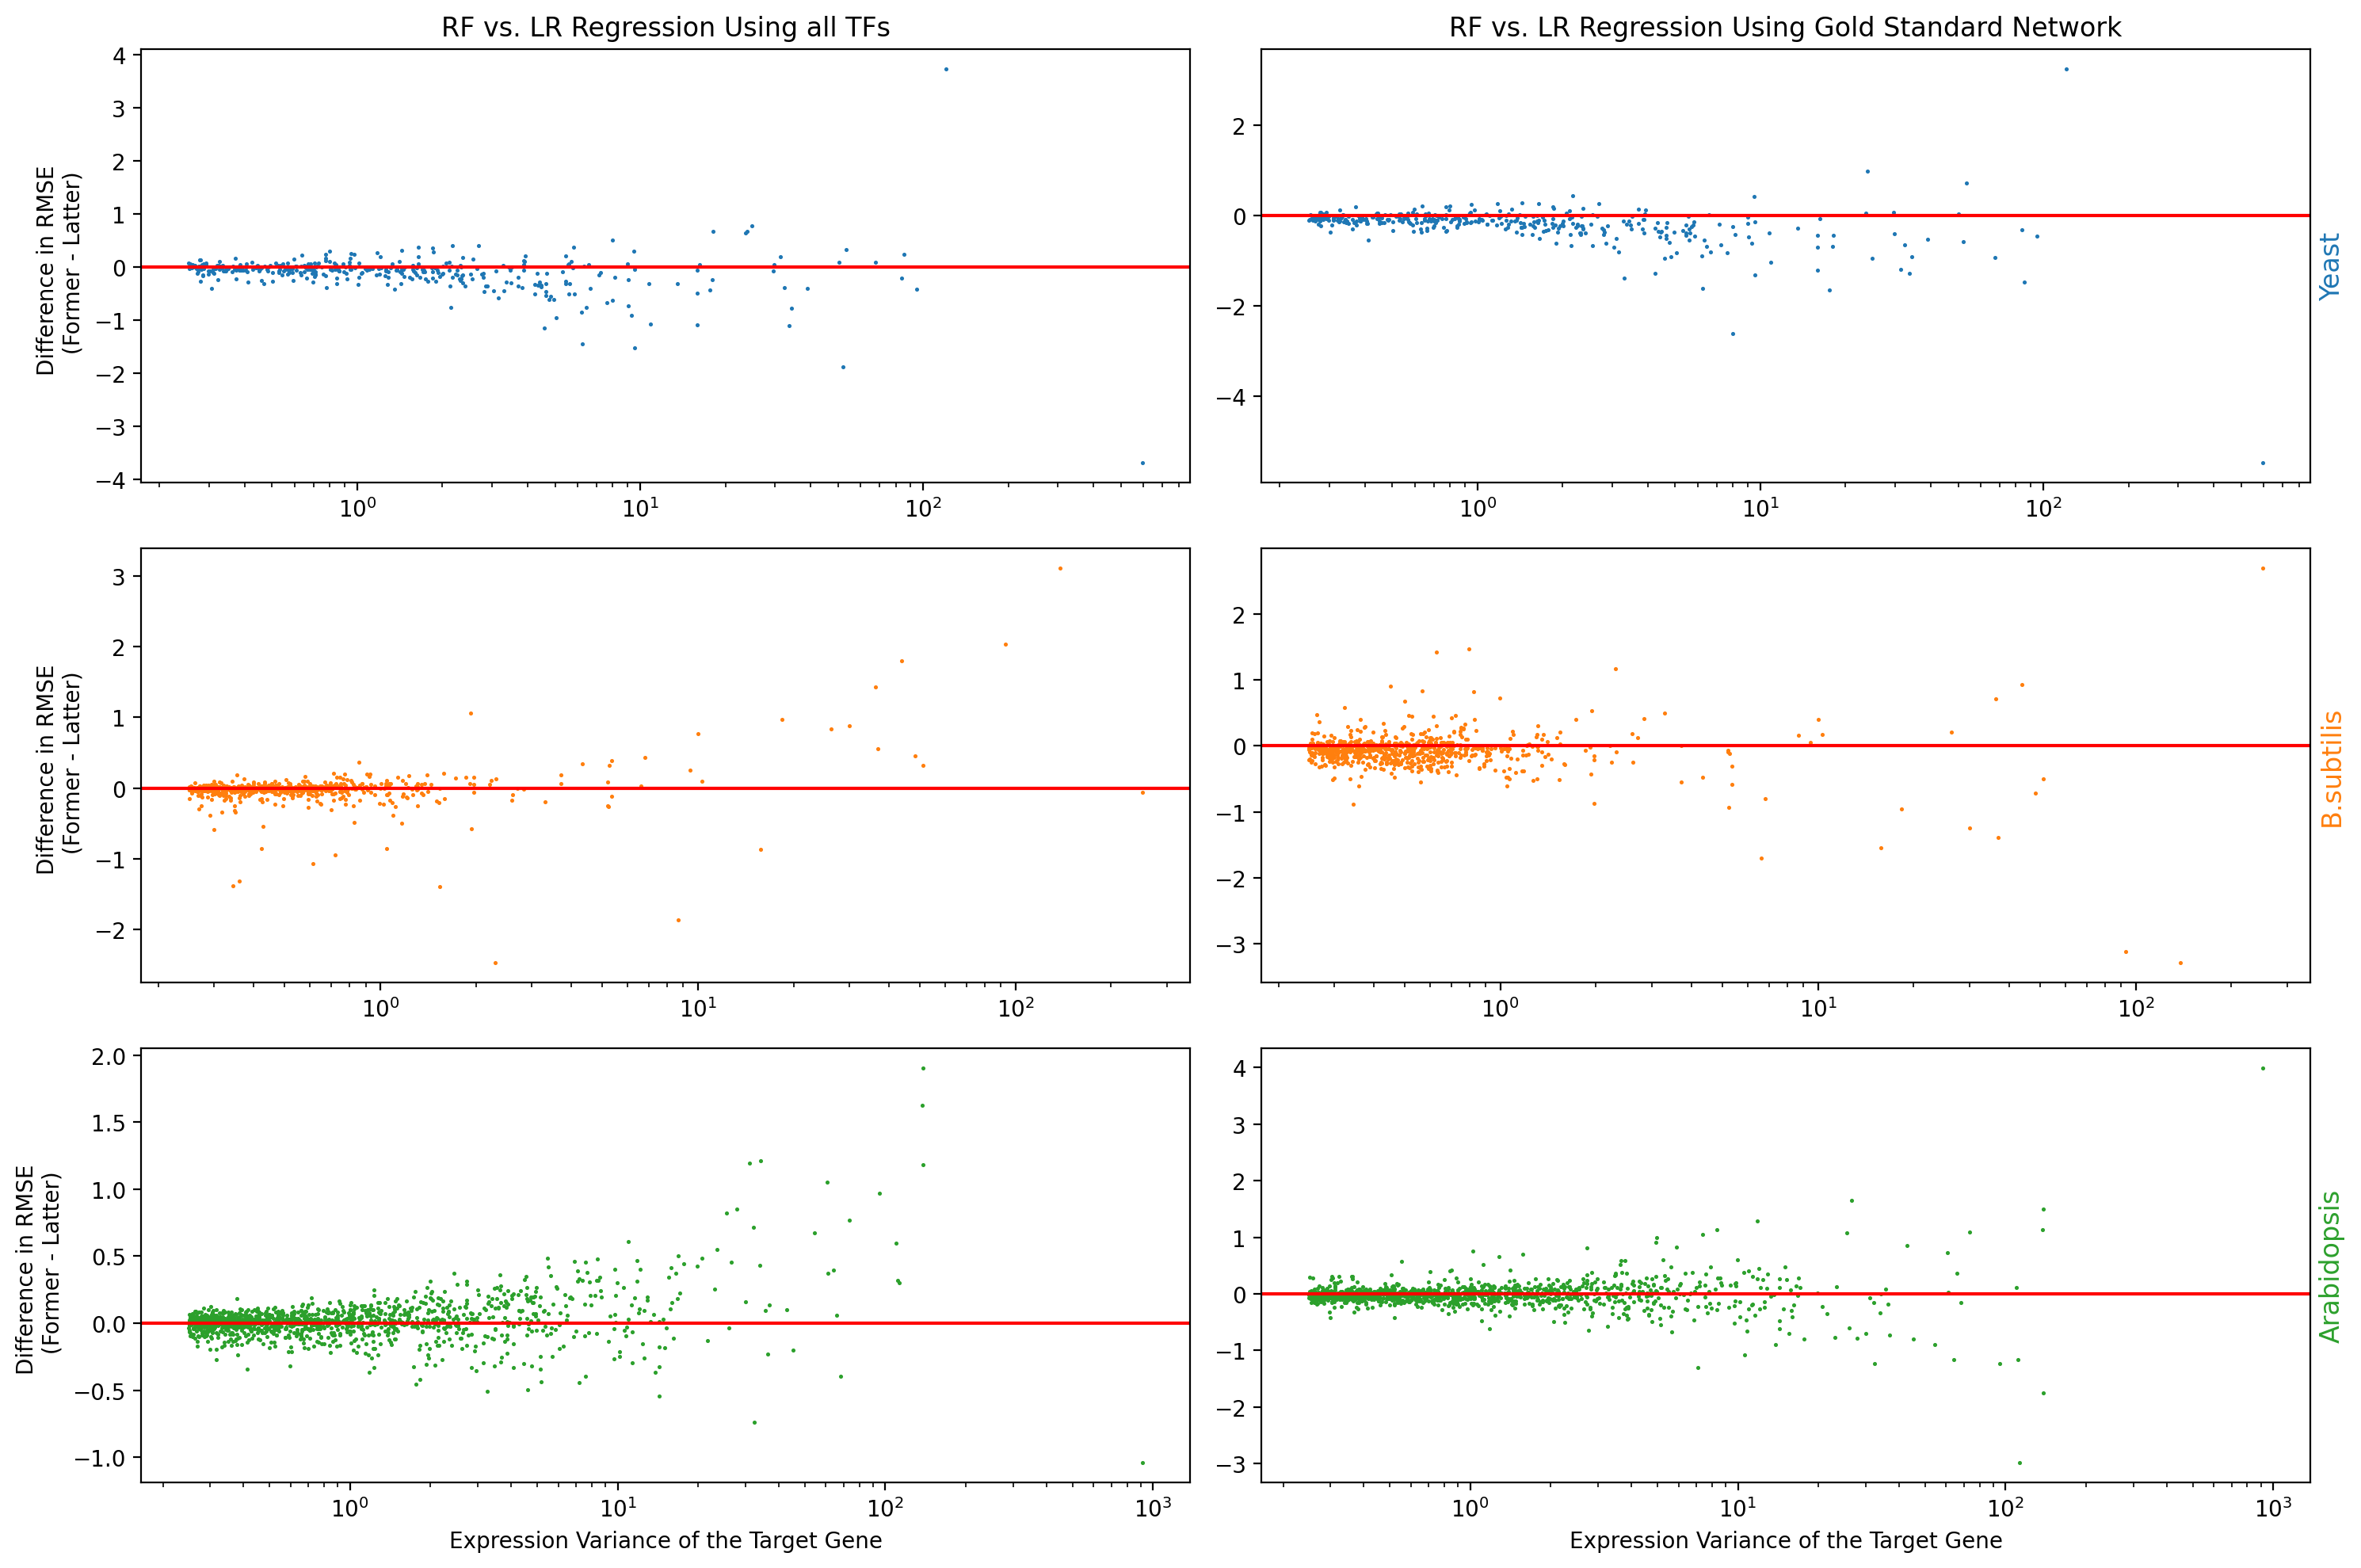

In [93]:
a = 'rf_rmse'
b = 'linear_rmse'
c = 'gs_rf_rmse'
d = 'gs_linear_rmse'

fig, axs = plt.subplots(3, 2, figsize=(15, 10))

for i in range(3):
    df = filtered_df_list[i]
    diff = df[a] - df[b]
    axs[i, 0].scatter(df['test_var'], diff, s=0.7, color=plt.cm.tab10(i))
    # plt.scatter(range(len(diff)),diff, s=0.2)
    axs[i, 0].axhline(y=0, color='r', linestyle='-')
    axs[i, 0].set_xscale('log')
    
    diff = df[c] - df[d]
    axs[i, 1].scatter(df['test_var'], diff, s=0.7, color=plt.cm.tab10(i))
    # plt.scatter(range(len(diff)),diff, s=0.2)
    axs[i, 1].axhline(y=0, color='r', linestyle='-')
    axs[i, 1].set_xscale('log')
    
for i in range(3):
    axs[i, 0].set(ylabel='Difference in RMSE \n (Former - Latter)')
    axs[i, 1].set_ylabel(species_names[i], color=plt.cm.tab10(i), size='large')
    axs[i, 1].yaxis.set_label_position("right")

axs[2, 0].set(xlabel='Expression Variance of the Target Gene')
axs[2, 1].set(xlabel='Expression Variance of the Target Gene')

axs[0, 0].set_title('RF vs. LR Regression Using all TFs')
axs[0, 1].set_title('RF vs. LR Regression Using Gold Standard Network')
fig.tight_layout()
fig.savefig('./plot_output/rf_v_lr.pdf', format='pdf', dpi=300)

In [99]:
model_name_dict = {
    'rf_rmse': 'RF with all TFs',
    'linear_rmse': 'LR with all TFs',
    'gs_rf_rmse': 'RF with GS network',
    'gs_linear_rmse': 'LR with GS network',
}

In [3]:
model_compare_combs = [('rf_rmse', 'gs_rf_rmse'),
 ('linear_rmse', 'gs_linear_rmse'),
 ('rf_rmse', 'linear_rmse'),
 ('gs_rf_rmse', 'gs_linear_rmse'),
 ('rf_rmse', 'gs_linear_rmse'),
 ('gs_rf_rmse', 'linear_rmse')]

In [107]:
len(filtered_df_list[2])

1373

In [104]:
paired_ttest_df = pd.DataFrame(index=range(len(model_compare_combs)))
paired_ttest_df['Model_A'] = [model_name_dict[key] for key in np.array(model_compare_combs)[:, 0]]
paired_ttest_df['Model_B'] = [model_name_dict[key] for key in np.array(model_compare_combs)[:, 1]]

res_df = filtered_df_list[2]

mean_list = []
ci_list = []
p_list = []

stats_res = stats.ttest_rel(res_df['linear_rmse'], res_df['gs_linear_rmse'])
for a, b in model_compare_combs:
    t_res = stats.ttest_rel(res_df[a], res_df[b])
    ci_res = t_res.confidence_interval()
    mean = (res_df[a] - res_df[b]).mean()
    mean_list.append(f'{mean:.3}')
    ci_list.append('('+f'{ci_res[0]:.3}'+', '+f'{ci_res[1]:.3}'+')')
    p_list.append(f'{t_res[1]:.3}')

paired_ttest_df['Mean Difference'] = mean_list
paired_ttest_df['95% Confidence Interval of Difference'] = ci_list
paired_ttest_df['p-value'] = p_list
paired_ttest_df.to_csv('./plot_output/ttest_res.csv', index=False)

In [103]:
paired_ttest_df

,Model_A,Model_B,Mean Difference,95% Confidence Interval of Difference,p-value
0,RF with all TFs,RF with GS network,-0.143,"(-0.167, -0.12)",7.62e-31
1,LR with all TFs,LR with GS network,-0.206,"(-0.243, -0.168)",3.74e-25
2,RF with all TFs,LR with all TFs,-0.0148,"(-0.0336, 0.00406)",0.124
3,RF with GS network,LR with GS network,-0.0771,"(-0.0997, -0.0544)",4.8e-11
4,RF with all TFs,LR with GS network,-0.22,"(-0.246, -0.195)",5e-56
5,RF with GS network,LR with all TFs,0.129,"(0.0969, 0.16)",7.25e-15


In [7]:
filtered = res_df.sort_values(['test_std'], ascending=False).head(int(len(res_df)*0.95))

In [8]:
filtered = res_df[res_df['test_std'] > 0.5]

In [9]:
paired_ttest_df = pd.DataFrame(index=range(len(model_compare_combs)))
paired_ttest_df['Model_A'] = [model_name_dict[key] for key in np.array(model_compare_combs)[:, 0]]
paired_ttest_df['Model_B'] = [model_name_dict[key] for key in np.array(model_compare_combs)[:, 1]]

mean_list = []
ci_list = []
p_list = []

stats_res = stats.ttest_rel(filtered['linear_rmse'], filtered['gs_linear_rmse'])
for a, b in model_compare_combs:
    t_res = stats.ttest_rel(filtered[a], filtered[b])
    ci_res = t_res.confidence_interval()
    mean = (filtered[a] - filtered[b]).mean()
    mean_list.append(f'{mean:.3}')
    ci_list.append('('+f'{ci_res[0]:.3}'+', '+f'{ci_res[1]:.3}'+')')
    p_list.append(f'{t_res[1]:.3}')

paired_ttest_df['Mean Difference'] = mean_list
paired_ttest_df['95% Confidence Interval of Difference'] = ci_list
paired_ttest_df['p-value'] = p_list

In [10]:
paired_ttest_df

,Model_A,Model_B,Mean Difference,95% Confidence Interval of Difference,p-value
0,RF with all TFs,RF with GS network,-0.0339,"(-0.0455, -0.0223)",1.9e-08
1,Linear with all TFs,Linear with GS network,-0.128,"(-0.157, -0.0999)",2.59e-17
2,RF with all TFs,Linear with all TFs,-0.104,"(-0.144, -0.0653)",2.49e-07
3,RF with GS network,Linear with GS network,-0.199,"(-0.245, -0.152)",8.12e-16
4,RF with all TFs,Linear with GS network,-0.233,"(-0.283, -0.182)",6.34e-18
5,RF with GS network,Linear with all TFs,-0.0705,"(-0.107, -0.0341)",0.000162


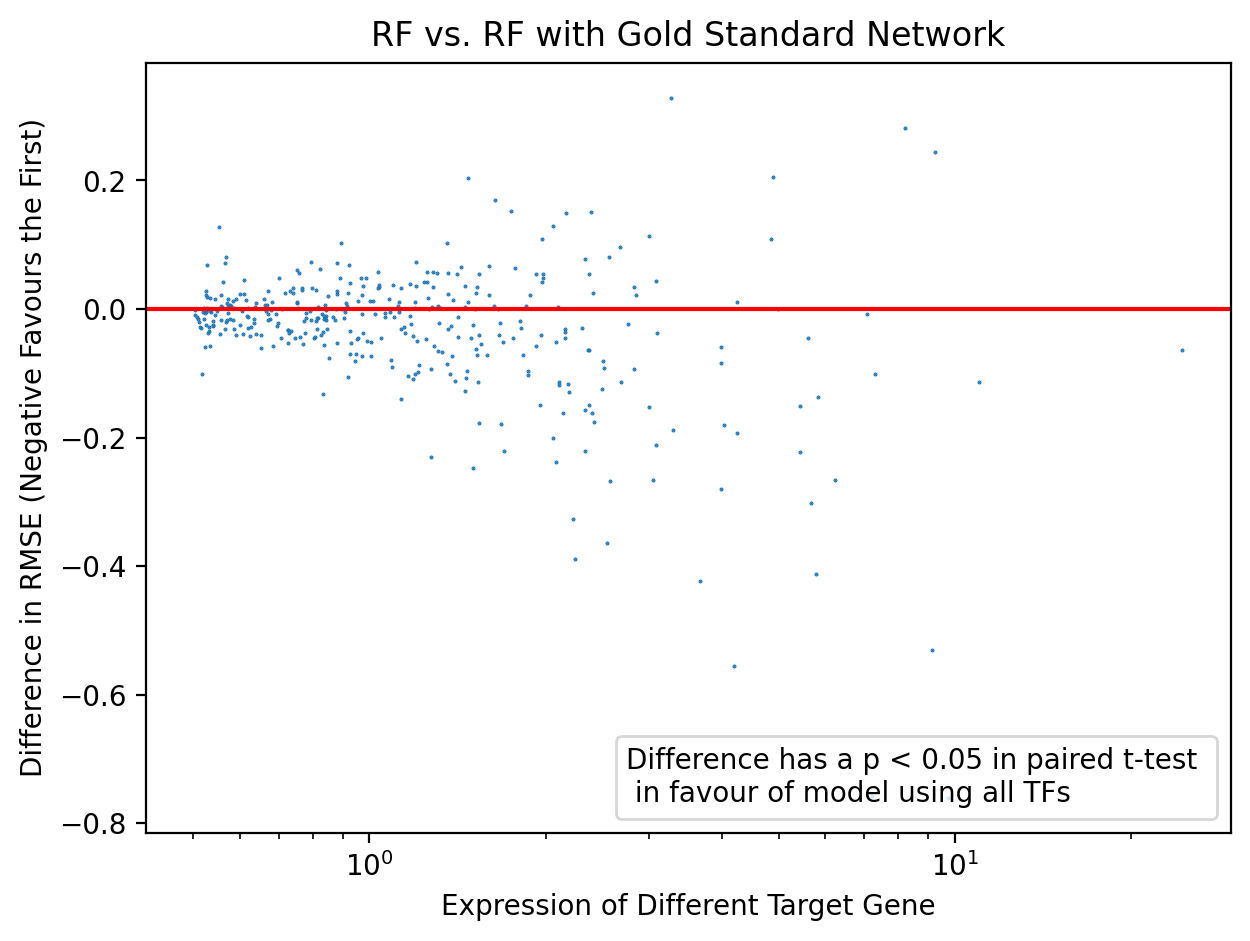

In [15]:
sorted_res_df = res_df.sort_values('rf_rmse', ascending=False)
# filtered = sorted_res_df[(res_df['rf_rmse']<rmse_threshold) & (sorted_res_df['gs_rf_rmse']<rmse_threshold)]
diff = filtered['rf_rmse'] - filtered['gs_rf_rmse']
plt.scatter(filtered['test_std'],diff, s=0.2)
# plt.scatter(range(len(diff)),diff, s=0.2)
plt.axhline(y=0, color='r', linestyle='-', label='Difference has a p < 0.05 in paired t-test \n in favour of model using all TFs')
plt.xscale('log')
# plt.tick_params(
#     axis='x',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     labelbottom=False) # labels along the bottom edge are off
plt.xlabel('Expression of Different Target Gene')
plt.ylabel('Difference in RMSE (Negative Favours the First)')
plt.title('RF vs. RF with Gold Standard Network')
plt.legend(handlelength=0, handletextpad=-.05, loc='lower right')
plt.show()

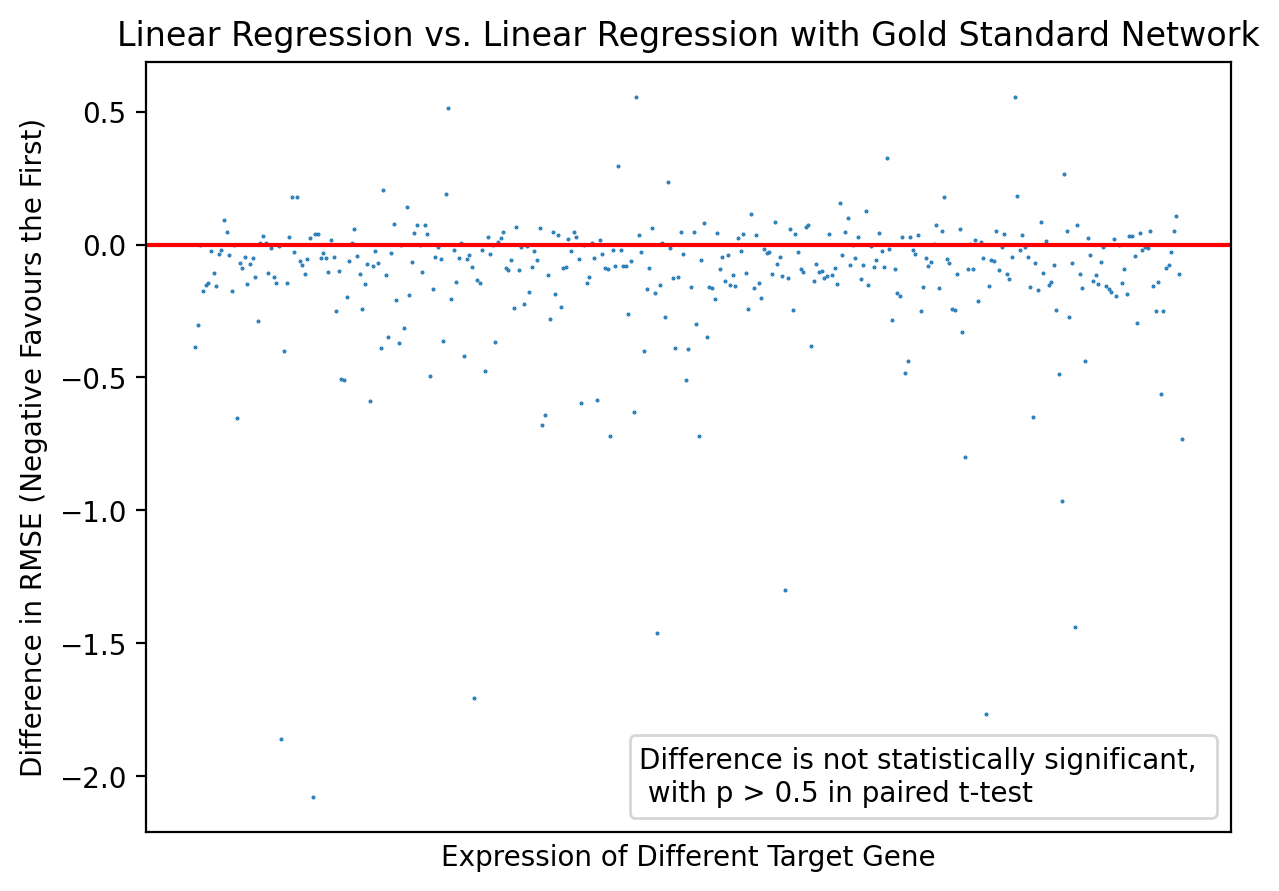

In [44]:
sorted_res_df = res_df.sort_values('linear_rmse', ascending=False)
# filtered = sorted_res_df[(res_df['linear_rmse']<rmse_threshold) & (sorted_res_df['gs_linear_rmse']<rmse_threshold)]
diff = filtered['linear_rmse'] - filtered['gs_linear_rmse']
plt.scatter(range(len(diff)),diff, s=0.2)
plt.axhline(y=0, color='r', linestyle='-', label='Difference is not statistically significant, \n with p > 0.5 in paired t-test')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.xlabel('Expression of Different Target Gene')
plt.ylabel('Difference in RMSE (Negative Favours the First)')
plt.title('Linear Regression vs. Linear Regression with Gold Standard Network')
plt.legend(handlelength=0, handletextpad=-.05, loc='lower right')
plt.show()

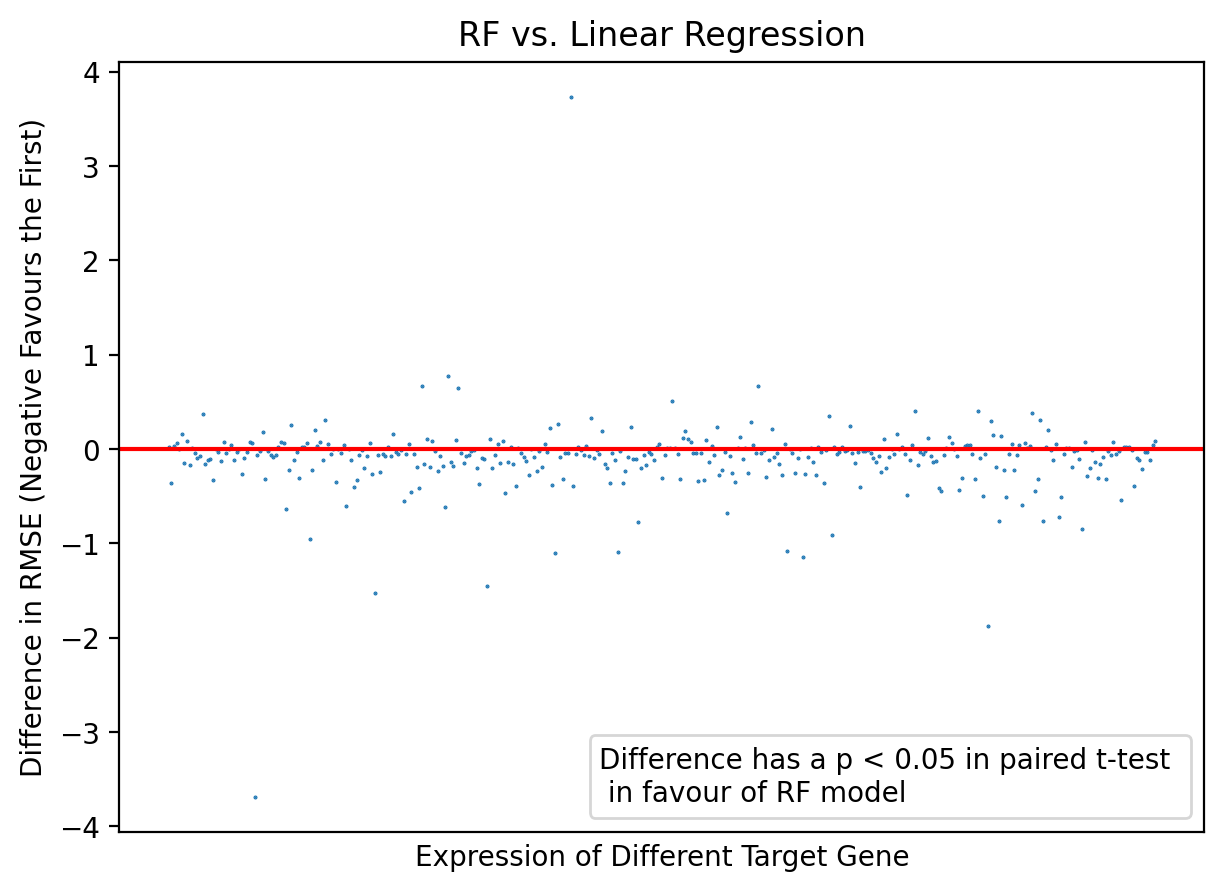

In [45]:
sorted_res_df = res_df.sort_values('rf_rmse', ascending=False)
# filtered = sorted_res_df[(res_df['rf_rmse']<rmse_threshold) & (sorted_res_df['linear_rmse']<rmse_threshold)]
diff = filtered['rf_rmse'] - filtered['linear_rmse']
plt.scatter(range(len(diff)),diff, s=0.2)
plt.axhline(y=0, color='r', linestyle='-', label='Difference has a p < 0.05 in paired t-test \n in favour of RF model')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.xlabel('Expression of Different Target Gene')
plt.ylabel('Difference in RMSE (Negative Favours the First)')
plt.title('RF vs. Linear Regression')
plt.legend(handlelength=0, handletextpad=-.05, loc='lower right')
plt.show()

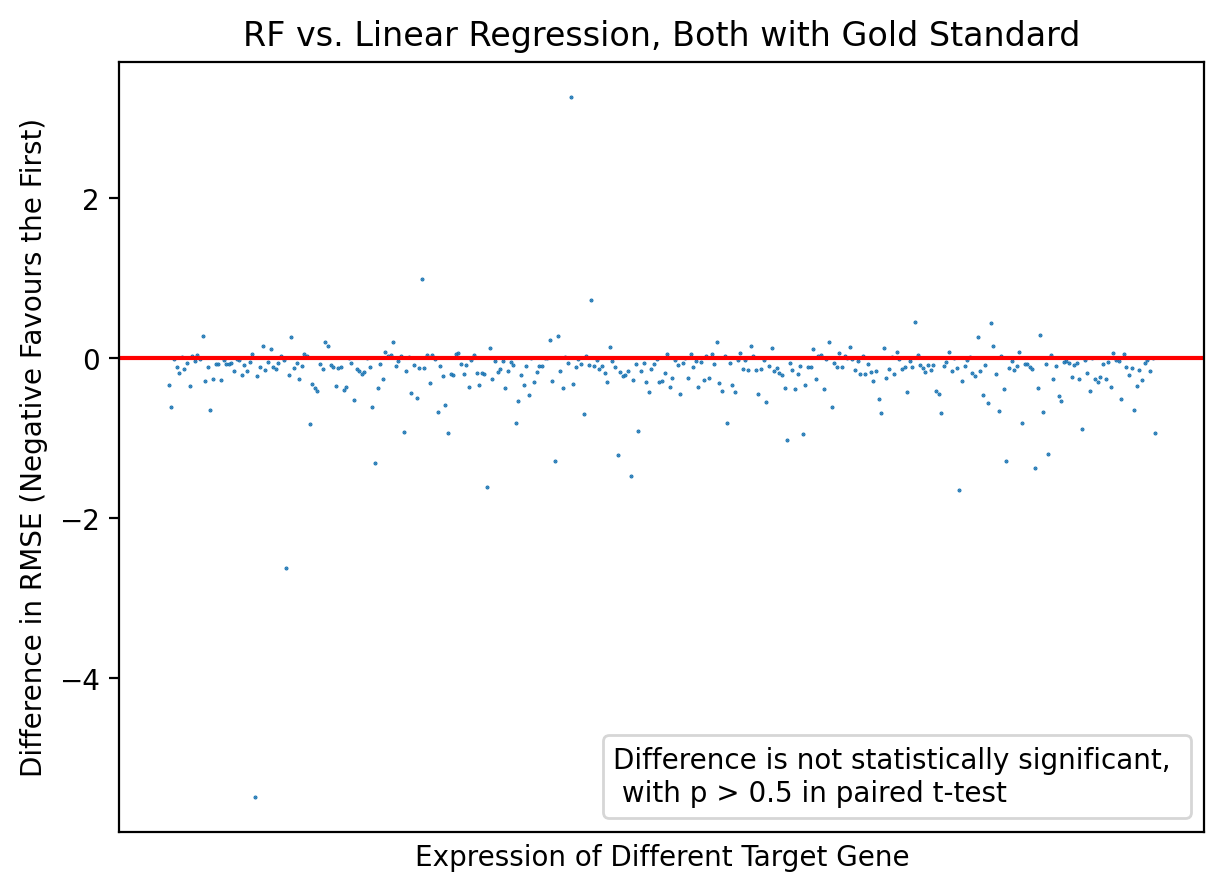

In [46]:
sorted_res_df = res_df.sort_values('gs_rf_rmse', ascending=False)
# filtered = sorted_res_df[(res_df['gs_rf_rmse']<rmse_threshold) & (sorted_res_df['gs_linear_rmse']<rmse_threshold)]
diff = filtered['gs_rf_rmse'] - filtered['gs_linear_rmse']
plt.scatter(range(len(diff)),diff, s=0.2)
plt.axhline(y=0, color='r', linestyle='-', label='Difference is not statistically significant, \n with p > 0.5 in paired t-test')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.xlabel('Expression of Different Target Gene')
plt.ylabel('Difference in RMSE (Negative Favours the First)')
plt.title('RF vs. Linear Regression, Both with Gold Standard')
plt.legend(handlelength=0, handletextpad=-.05, loc='lower right')
plt.show()

In [10]:
t, p = stats.ttest_rel(res_df['gs_rf_rmse'], res_df['gs_linear_rmse'])
print(t, p)

-0.5246712923526721 0.6002004891189054


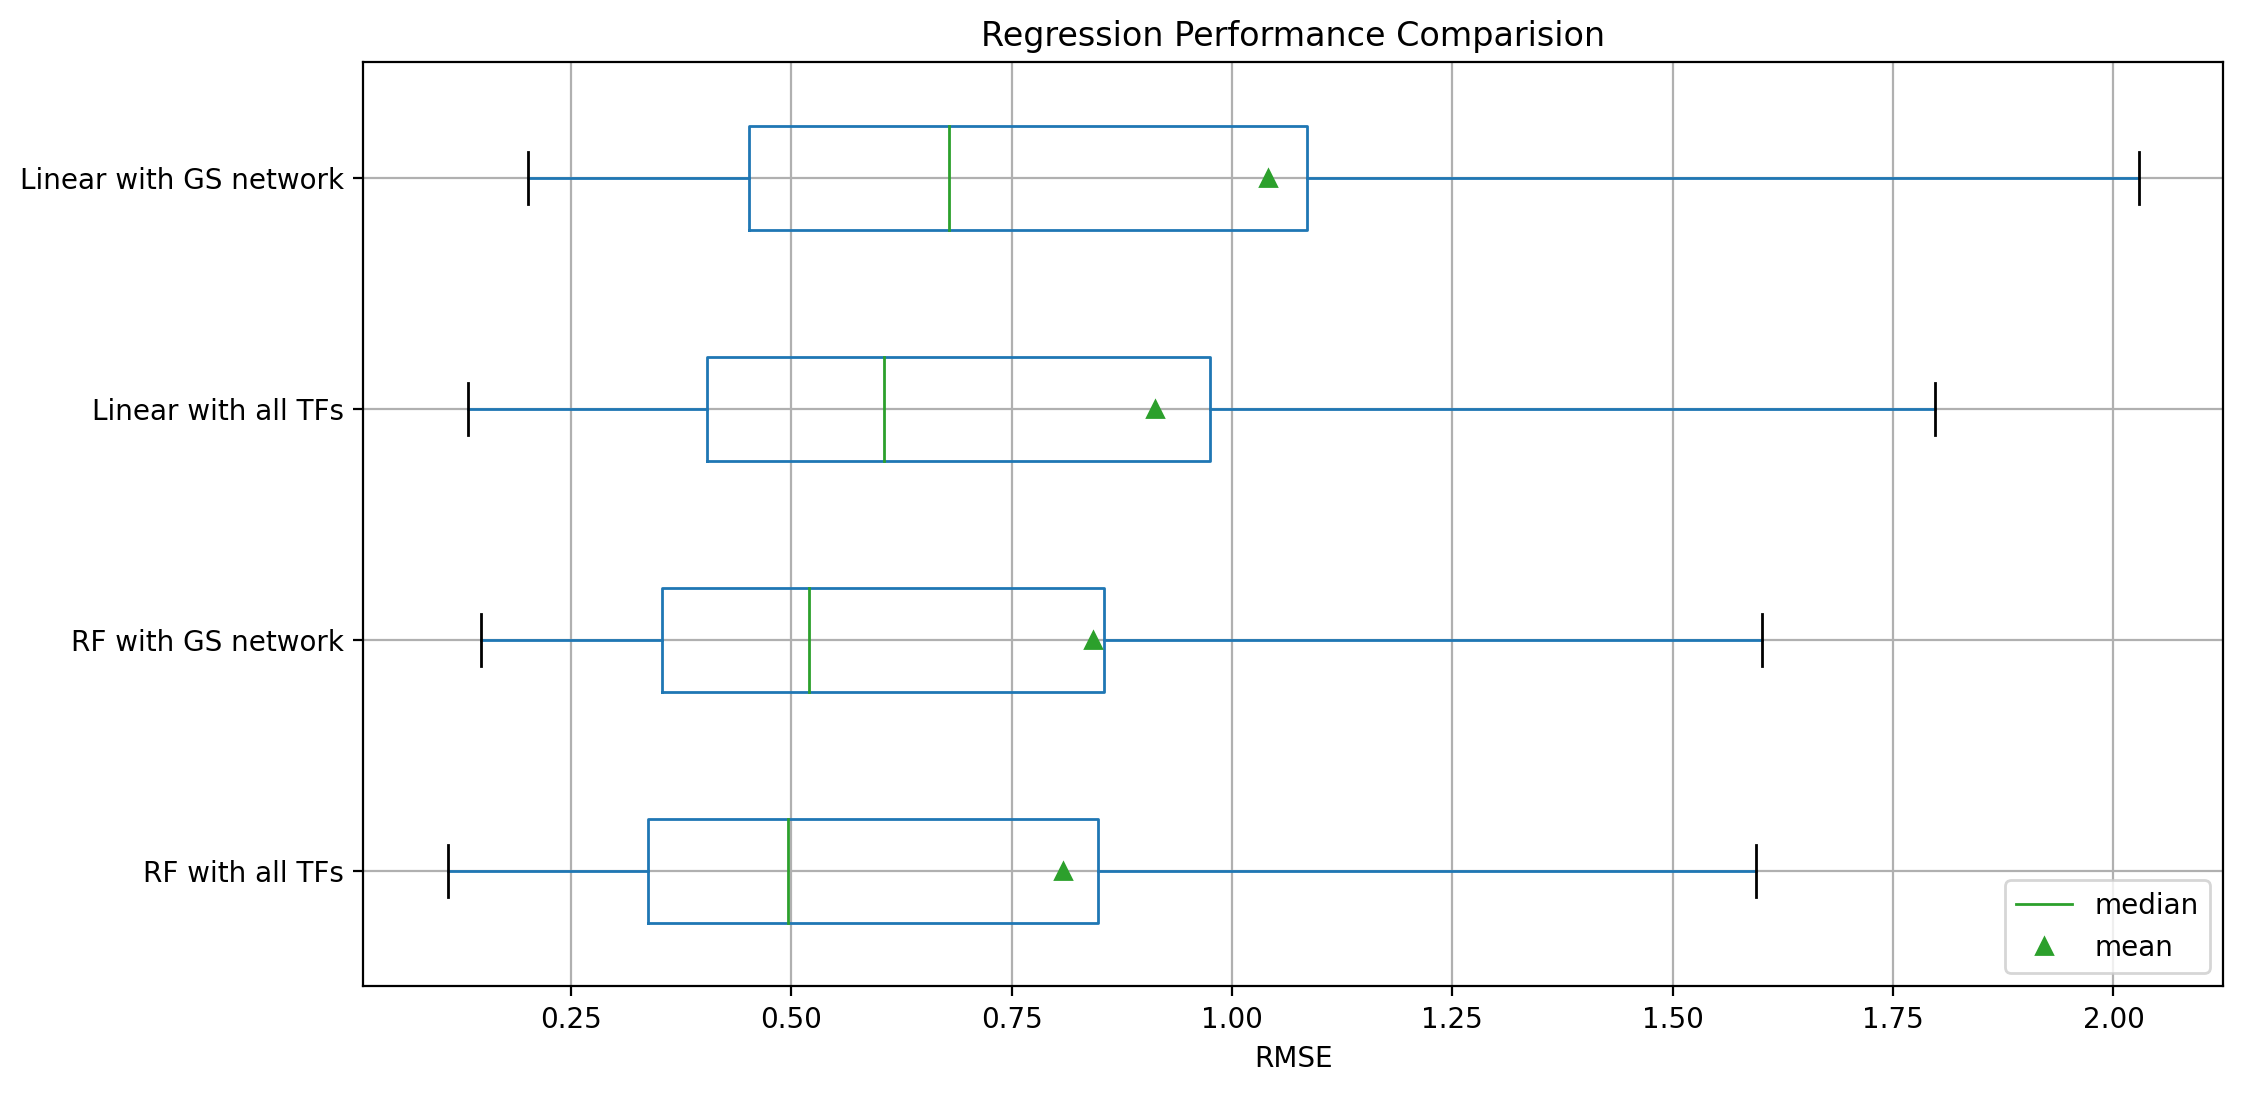

In [49]:
plt.figure(figsize=(12,6))
bp  = res_df.iloc[:, [6,8,7,9]].boxplot(showfliers=False, showmeans=True, vert=False, return_type='dict')
plt.xlabel('RMSE')
plt.yticks(ticks=range(1,5), labels=['RF with all TFs', 'RF with GS network', 'Linear with all TFs', 'Linear with GS network'])
plt.legend([bp['medians'][0], bp['means'][0]], ['median', 'mean'])
plt.title('Regression Performance Comparision')
plt.show()